In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm 

REBUILD_DATA = True

In [2]:
#creating our data class

class cells():
    IMG_SIZE = 50
    
    #getting data from directory
    PARASITIZED = "Parasitized"
    UNINFECTED = "Uninfected"
    
    LABELS = {PARASITIZED : 0, UNINFECTED : 1}
    
    training_data = []
    badcount = 0
    goodcount = 0
    
    #getting our data ready
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.PARASITIZED:
                        self.badcount += 1
                    elif label == self.UNINFECTED:
                        self.goodcount += 1
                        
                except Exception as e:
                    pass
                    
       #shuffling our data                                 
        np.random.shuffle(self.training_data)
        
        #saving the data in the directory
        np.save("training_data.npy", self.training_data)
        
        print("Parasitized: ", self.badcount)
        print("Uninfected: ", self.goodcount)

In [3]:
#making an instance of our data class and running the make_training_data function
if REBUILD_DATA:
    data = cells()
    data.make_training_data()

  0%|          | 0/900 [00:00<?, ?it/s]

Parasitized


  1%|          | 7/733 [00:00<00:10, 66.62it/s]

Uninfected


100%|██████████| 733/733 [00:10<00:00, 68.46it/s]
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Parasitized:  899
Uninfected:  733


In [13]:
#loading our data to the variable training_data
training_data = np.load("training_data.npy", allow_pickle=True)

In [14]:
#how big is our training data set?
print(len(training_data))

1632


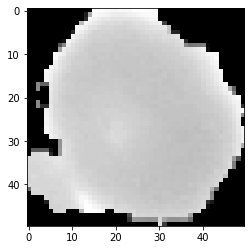

In [15]:
#visualizing one of the images
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap = 'gray')
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
#creating a neural network class
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50, 50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        #fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512,2)
    
    #defining how we pass data through the convolutional layers
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2,))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2,))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2,))
        
        print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    #passing the data through the convolutional layers as well as the fully connected ones
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        
        #first fully connected layer, we run the ReLu acitvation function on this layer
        x = F.relu(self.fc1(x))
        
        #second fully connected layer
        x = self.fc2(x)
        
        #softmax activation function on output layer
        return F.softmax(x, dim = 1)
    

net = Net()
            

[2020-12-14 01:03:12.919 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-594def216eaae0b31fbf025840e5:737 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2020-12-14 01:03:13.079 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-594def216eaae0b31fbf025840e5:737 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
torch.Size([128, 2, 2])


In [9]:
#optimizer
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr = 0.001)

loss_function = nn.MSELoss() 

#converting images to tensors
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)

print(val_size)

163


In [10]:
#seperating training and testing data
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

1469
163


In [ ]:
#training the neural network 
BATCH_SIZE = 100

EPOCHS = 10

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
print(loss)

 13%|█▎        | 2/15 [00:00<00:01,  9.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 4/15 [00:00<00:01,  8.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 6/15 [00:00<00:00,  9.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 8/15 [00:00<00:00,  9.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 10/15 [00:01<00:00,  9.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 12/15 [00:01<00:00,  9.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 14/15 [00:01<00:00,  8.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 1/15 [00:00<00:01,  9.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 4/15 [00:00<00:01,  9.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 6/15 [00:00<00:00,  9.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 8/15 [00:00<00:00,  9.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 10/15 [00:01<00:00,  9.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 12/15 [00:01<00:00,  9.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 14/15 [00:01<00:00,  9.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 1/15 [00:00<00:01,  9.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 4/15 [00:00<00:01,  9.52it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 6/15 [00:00<00:00,  9.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 8/15 [00:00<00:00,  9.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 10/15 [00:01<00:00,  9.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 12/15 [00:01<00:00,  9.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 14/15 [00:01<00:00,  8.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 1/15 [00:00<00:01,  8.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 3/15 [00:00<00:01,  8.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 5/15 [00:00<00:01,  8.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 7/15 [00:00<00:00,  8.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 9/15 [00:00<00:00,  9.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 11/15 [00:01<00:00,  9.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 13/15 [00:01<00:00,  9.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 0/15 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 2/15 [00:00<00:01,  9.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 4/15 [00:00<00:01,  8.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 5/15 [00:00<00:01,  7.63it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 8/15 [00:00<00:00,  8.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 9/15 [00:01<00:00,  8.95it/s]

In [12]:
#testing the accuracy of our model
correct = 0 
total = 0 

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        
        if predicted_class == real_class:
            correct += 1
        total += 1
        
print("Accuracy", round(correct/total,3))

 72%|███████▏  | 118/163 [00:00<00:00, 584.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 163/163 [00:00<00:00, 574.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,